# Grenoble Data Science Meet-up
## An (intermediate) tutorial on (flat) text classification using scikit-learn

The main goals of the tutorial are to investigate the following:
- Text loading, cleaning and encoding issues
- Text vectorization using either counts or a hashing function + weighting schemes
- Validation using hold out or k-fold cross validation
- Performance evaluation using several families of classifiers (trees, svms, logistic regression, naive bayes)
- Grid search to fine tune the above systems.

## Data loading.
We live in a multi-lingual world. Unicode is our tool to handle languages/symbols etc.

In [16]:
#Load the data
raw_data = codecs.open('/home/balikasg/wikipediaData/data.meeptup.txt', 'r', encoding='utf8').read().splitlines() #Use codecs for handling noo-ASCII characters etc..
labels = codecs.open('/home/balikasg/wikipediaData/labels.meeptup.txt', 'r', encoding='utf8').read().splitlines() #Here codecs is not necessary
labels = [int(x.split(';')[2]) for x in labels] # From the labels, take only the leaf class, i.e., flat approach

### Exploratory Analysis
We calculate and plot some of the aspects of our data.


Number of Documents: 2825
Average length of docs.: 95.105840708
Different classes: 170


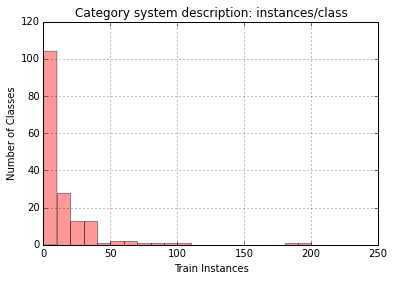

In [17]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print "Number of Documents:", len(raw_data)
print "Average length of docs.:", sum([len(x.split()) for x in raw_data])/float(len(raw_data))
print "Different classes:", len(set(labels))

# print "Instances per class:", Counter(labels)
plt.hist(Counter(labels).values(), bins=np.arange(0, 215, 10), color='r', alpha=0.4)
plt.grid()
plt.title("Category system description: instances/class")
plt.xlabel("Train Instances")
plt.ylabel("Number of Classes")




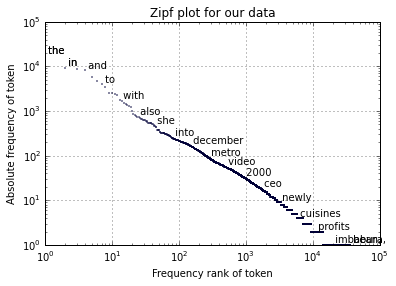

In [18]:
import math
tokens_with_count = Counter([y.lower() for x in raw_data for y in x.split()])
counts = np.array(tokens_with_count.values())
tokens = tokens_with_count.keys()
ranks = np.arange(1, len(counts)+1)
indices = np.argsort(-counts)
frequencies = counts[indices]
plt.plot(ranks, frequencies, 'o', markersize=0.9)
plt.yscale('log')
plt.xscale('log')
plt.title("Zipf plot for our data")
plt.xlabel("Frequency rank of token")
plt.ylabel("Absolute frequency of token")
plt.grid()
for n in list(np.logspace(-0.5, math.log10(len(counts)-1), 20).astype(int)):
    dummy = plt.text(ranks[n], frequencies[n], " " + tokens[indices[n]],   verticalalignment="bottom", horizontalalignment="left")


## Vectorization
Given text spans to be classified, the goals of the the step are the following:
+ load the data,
+ clean and preprocess them,
+ tokenize them, and
+ generate a vocabulary of n-grams and output the sparse vector matrix

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, HashingVectorizer, TfidfVectorizer

# Define an example string to demnostrate the different steps of vectorization
string = "I want to learn text classification with Python."

my_vec = CountVectorizer(ngram_range=(1,1)) #http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
print "Original string:", string
print "Preprocess:", my_vec.build_preprocessor()(string)
print "Tokenizer:", my_vec.build_tokenizer()(string)
print "Analyzer:", my_vec.build_analyzer()(string)
#Hint: why "I" does not appear? (token_pattern='(?u)\b\w\w+\b')

Original string: I want to learn text classification with Python.
Preprocess: i want to learn text classification with python.
Tokenizer: ['want', 'to', 'learn', 'text', 'classification', 'with', 'Python']
Analyzer: [u'want', u'to', u'learn', u'text', u'classification', u'with', u'python']


## Feature selection and transformation
The goal here it to select the most prominent features and/or apply a weighting scheme that will put emphasis on the some of them, just using the frequencies of their occurrence in the corpus. 
+ max_df = 1
+ min_df = 1
+ max_features = None

The above-meantioned are hyper-parameters to be tuned. 

In [20]:
from sklearn import  cross_validation, preprocessing
import scipy.sparse as sp

#Split the raw data in train/test. Use test *only* for testing. We will use this in the next cell.
x_train_raw, x_test_raw, y_train, y_test = cross_validation.train_test_split(raw_data, labels, train_size=0.75,random_state=123)

## Learning
At this point the data have been projected to a vector space (i.e., each instance is a vector). This is a suitable data representation, that can be consequently fed in learning algorithm. Before that though, split..

Machine learning algorithms must be evaluated on *unseen* data, that is data not belonging to the train data. The most straighforward approach is to split the data on train/test parts, and learn/evaluate the algorithm on the respective part. 

In [21]:
#We will evaluate several representations. Hence, we make a dictionary that will keep the train/test data for each representation
my_representations = list()
for name, vectorizer in zip(['tf', 'hashing', 'tfidf', ],[CountVectorizer(ngram_range=(1,1)), HashingVectorizer(n_features=10000, non_negative=True), TfidfVectorizer()]):
    vectorizer.fit(x_train_raw)
    my_representations.append({"name":name, "x_train":vectorizer.transform(x_train_raw), "x_test":vectorizer.transform(x_test_raw)})
    if name == 'tf':
        print len(vectorizer.vocabulary_)

19228


Scikit-learn offers access to a plethora of classifiers with the same API calls. In short, one must call the "fit" methods to learn the model's parameters and "predict" to get the predictions for data instances. Here is a non-exhaustive list of classifiers we will benchmark for our multi-class problem.
+ Naive bayes 
+ Logistic Regression
+ Support Vector Machines with linear kernel
+ Random Forests

In [22]:
from sklearn import naive_bayes, linear_model, svm, ensemble, neighbors, metrics

# Set hyper-parameters, for controlling algorithm
learners = [{"name":"LR", "model":linear_model.LogisticRegression(C=1)}, 
            {"name":"SVM", "model":svm.LinearSVC(C=1)}, 
            {"name":"5-NN", "model":neighbors.KNeighborsClassifier(n_neighbors=5)}, 
            {"name":"Rochio", "model":neighbors.NearestCentroid()}, 
            {"name":"N.B.", "model":naive_bayes.MultinomialNB(alpha=1)}]

# Loop and test the performance of each of the above learners
for representation in my_representations:
    print "\tRepresentation:", representation["name"]
    for learner in learners:
        learner['model'].fit(representation["x_train"], y_train)
        preds = learner['model'].predict(representation["x_test"])
        print "%s:\tAccuracy: %0.3f\tF1 macro: %0.3f"%(learner['name'], metrics.accuracy_score(y_test, preds), metrics.f1_score(y_test, preds, average='macro')) 
    print "----------------"

    
# Maybe: Make a comment on performance evaluation using cv    

	Representation: tf
LR:	Accuracy: 0.634	F1 macro: 0.353
SVM:	Accuracy: 0.651	F1 macro: 0.390
5-NN:	Accuracy: 0.471	F1 macro: 0.233
Rochio:	Accuracy: 0.330	F1 macro: 0.196
N.B.:	Accuracy: 0.390	F1 macro: 0.113
----------------
	Representation: hashing
LR:	Accuracy: 0.463	F1 macro: 0.170
SVM:	Accuracy: 0.644	F1 macro: 0.345
5-NN:	Accuracy: 0.516	F1 macro: 0.257
Rochio:	Accuracy: 0.516	F1 macro: 0.320
N.B.:	Accuracy: 0.242	F1 macro: 0.027
----------------
	Representation: tfidf
LR:	Accuracy: 0.515	F1 macro: 0.202
SVM:	Accuracy: 0.676	F1 macro: 0.457
5-NN:	Accuracy: 0.595	F1 macro: 0.343
Rochio:	Accuracy: 0.628	F1 macro: 0.394
N.B.:	Accuracy: 0.303	F1 macro: 0.054
----------------


/home/balikasg/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/balikasg/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:960: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Optimizing with GridSearch
Learning algorithms, vectorization and weighting schemes ect. usually come with hyper-parameters i.e., parameters with default values that have to be tuned in order to obtain optimal performance. k-fold cross validation in conjunction with grid search is probably the most common way of tuning such parameters. Note, that is can become very cpu/memory expensive for large problems, that is problems with many features or many instances or both.  

In [23]:
from sklearn import grid_search #http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html

# We will tune the C value of SVMs to optimize first accuracy and the f1_macro
for eval_meas in ["accuracy", "f1_macro"]:
    clf = grid_search.GridSearchCV(svm.LinearSVC(), param_grid={"C":[0.01, 0.1, 1, 10, 100]}, n_jobs=3, scoring=eval_meas, refit=True, cv=5)
    clf.fit(my_representations[2]["x_train"], y_train) # Note that GridSearchCV is itself an estimator
    print "Tuned SVM on %s (C=%0.2f):"%(eval_meas, clf.best_params_['C']), clf.score(my_representations[2]["x_test"], y_test)


/home/balikasg/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


Tuned SVM on accuracy (C=10.00): 0.700141442716


/home/balikasg/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:370: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


Tuned SVM on f1_macro (C=10.00): 0.487716569715


### Transformations (cont.)
There are several feature transformations and weighting schemes proposed. Inspired by the presentation on our cDiscount participation, we demonstrate here the a_power tranformation on the tf-idf scheme with SVMs, that performed the best above.

In [24]:
#Define a new tranformation: element-wise a_power
from sklearn.base import BaseEstimator, TransformerMixin
class A_PowerTransformer(BaseEstimator, TransformerMixin):
    """Transform document representations by element-wise exponentiation
        x=(b,c,...,d) -> x'=(b^a, c^a,...,d^a)
        If norm='l2' return normalised data.
    """
    def __init__(self, norm='l2', a_power=0.5):
        self.norm = norm
        self.a_power=a_power
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, copy=True):
        X = sp.csr_matrix(X, dtype=np.float64, copy=copy)
        X.data **= self.a_power
        if self.norm == 'l2':
            X = preprocessing.normalize(X, norm=self.norm, copy=False)
        return X


In [25]:
# Test the application of the tranformer
my_transfomer = A_PowerTransformer()
Xt_train = my_transfomer.transform(my_representations[2]["x_train"])
Xt_test  = my_transfomer.transform(my_representations[2]["x_test"])
clf = grid_search.GridSearchCV(svm.LinearSVC(), param_grid={"C":[0.01, 0.1, 1, 10, 100]}, n_jobs=3, scoring='accuracy', refit=True, cv=5)
clf.fit(Xt_train, y_train) 
print metrics.accuracy_score(y_test, clf.predict(Xt_test))
print clf.best_params_

0.710042432815
{'C': 100}


### Recap
We have investigated basic directions. In particular:

- Text vectorization strategies
- Tuning using stratified k-fold cross validation
- Application of different classifiers using the Sklearn API (fit/transform)
- Evaluation using different metrics

In [26]:
from sklearn.pipeline import Pipeline

# Define a sequence of steps...
estimators = [('vectorize', CountVectorizer()), ("powerTransformer", A_PowerTransformer()),  ('mySvm', svm.LinearSVC())]
clf = Pipeline(estimators) # .. group them with a Pipeline ..
params = dict(vectorize__ngram_range=[(1,1), (1,2)], powerTransformer__a_power=[0.3, 0.4, 0.5, 0.6], mySvm__C=[0.1, 1, 10, 100]) # .. set look-up parameters..
# Hint: we have just defined 32 parameter groups, i.e., 32 x 5 cross-validation problems, which is quite big.
tuned_clf = grid_search.GridSearchCV(clf, param_grid=params, n_jobs=3, refit=True, cv=5, ).fit(x_train_raw, y_train) # .. greed search optimize the whole pipeline

print  metrics.accuracy_score(y_test, tuned_clf.predict(x_test_raw))
print tuned_clf.best_params_


0.711456859972
{'powerTransformer__a_power': 0.6, 'vectorize__ngram_range': (1, 2), 'mySvm__C': 100}
